In [1]:
#0. Install Dependencies and Bring in Data

In [2]:
%pip install pandas matplotlib sklearn numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(r"c:\Users\aruls\Documents\jigsaw-toxic-comment-classification-challenge\train.csv")

In [5]:
df[df['threat']==1].head

<bound method NDFrame.head of                       id                                       comment_text  \
79      003217c3eb469ba9  Hi! I am back again!\nLast warning!\nStop undo...   
176     006b94add72ed61c  I think that your a Fagget get a oife and burn...   
600     0199d6af27b715f3  I'm also a sock puppet of this account...SUPRI...   
802     02230885017a50c5  Fuck you, Smith. Please have me notified when ...   
1017    02c6e41e4b317ac3  WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...   
...                  ...                                                ...   
157718  e26b106943e02cbf  bitch \nyou are a fucking hore. you suck dick ...   
158717  f264b7fb9a4b4f53  stupid head \n\nYOur dumb and you are stupid d...   
158856  f4dca9e513e0366f  Hey \n\nhey faggot, are you dead yet? or are y...   
159029  f780e4f42aa5a344                                Death to Musulmans!   
159400  fd052883fa6a8697  Shalom \n\nSemite, get the fuck out of here. I...   

        toxic  severe

In [6]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [12]:
# import gradio as gr

# def analyze_toxicity(comment):
#     # Here, you would typically use a toxicity analysis model to predict the indicators.
#     # Replace the following placeholders with actual code for toxicity analysis.
#     toxic = 0.5  # Replace with the actual toxicity prediction for "toxic"
#     severe_toxic = 0.3  # Replace with the actual toxicity prediction for "severe_toxic"
#     obscene = 0.4  # Replace with the actual toxicity prediction for "obscene"
#     threat = 0.2  # Replace with the actual toxicity prediction for "threat"
#     insult = 0.6  # Replace with the actual toxicity prediction for "insult"
#     identity_hate = 0.1  # Replace with the actual toxicity prediction for "identity_hate"
    
#     return {
#         "toxic": toxic,
#         "severe_toxic": severe_toxic,
#         "obscene": obscene,
#         "threat": threat,
#         "insult": insult,
#         "identity_hate": identity_hate
#     }

# iface = gr.Interface(
#     fn=analyze_toxicity,
#     inputs=gr.Textbox(label="Enter a comment:", placeholder="Type your comment here..."),
#     outputs=[
#         gr.Label(label="Toxic", type="number"),
#         gr.Label(label="Severe Toxic", type="number"),
#         gr.Label(label="Obscene", type="number"),
#         gr.Label(label="Threat", type="number"),
#         gr.Label(label="Insult", type="number"),
#         gr.Label(label="Identity Hate", type="number"),
#     ],
#     theme="dark",
#     live=True,
# )

# iface.launch()

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
#Create Sequential Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [53]:
history = model.fit(train, epochs=6, validation_data=val)

Epoch 1/6


6981/6981 [==============================] - 8261s 1s/step - loss: 0.0644 - val_loss: 0.0470
Epoch 2/6
6981/6981 [==============================] - 8678s 1s/step - loss: 0.0467 - val_loss: 0.0405
Epoch 3/6
6981/6981 [==============================] - 7069s 1s/step - loss: 0.0411 - val_loss: 0.0369
Epoch 4/6
6981/6981 [==============================] - 5740s 822ms/step - loss: 0.0369 - val_loss: 0.0314
Epoch 5/6
6981/6981 [==============================] - 52700s 8s/step - loss: 0.0334 - val_loss: 0.0300
Epoch 6/6
6981/6981 [==============================] - 5436s 779ms/step - loss: 0.0304 - val_loss: 0.0256


In [54]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

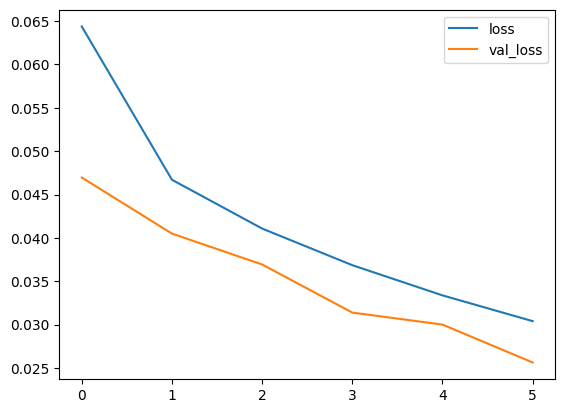

In [55]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [56]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [57]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [59]:
batch=test.as_numpy_iterator().next()

In [60]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [61]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 459ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [62]:
res=model.predict(batch_X)

1/1 [==============================] - 0s 159ms/step


In [63]:
res

array([[3.19039668e-06, 2.41922688e-33, 3.00136037e-07, 1.51496003e-13,
        1.76857792e-10, 1.74503925e-13],
       [2.79161432e-05, 8.48793919e-28, 3.10813039e-06, 1.50110913e-11,
        2.13902585e-09, 1.38189529e-11],
       [3.46546508e-02, 5.61046154e-10, 3.33299860e-03, 2.01053437e-04,
        1.74145692e-03, 1.91371262e-04],
       [6.94687362e-04, 2.90398453e-19, 1.62426499e-04, 1.68491159e-08,
        4.33931518e-06, 1.69263572e-08],
       [8.82407784e-01, 1.08444277e-04, 1.66503862e-02, 7.63167569e-04,
        9.90451574e-02, 5.18917618e-03],
       [3.06188216e-04, 7.60548649e-22, 3.36086487e-05, 1.02060449e-08,
        7.44632416e-07, 7.62514585e-09],
       [1.80505682e-04, 9.90021572e-23, 4.02277838e-05, 8.47939163e-10,
        1.97621205e-07, 1.19686983e-09],
       [9.88102518e-04, 1.13692666e-18, 1.22540718e-04, 6.88668536e-08,
        6.57015744e-06, 5.98542442e-08],
       [2.31734365e-02, 8.55753801e-11, 4.40483447e-03, 6.93613911e-05,
        1.35761464e-03, 

In [64]:
res.shape

(16, 6)

In [34]:
#evaluate model

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 171ms/step


In [68]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8759594559669495, Recall:0.4105035960674286, Accuracy:0.2657974064350128


c:\Users\aruls\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
#test and gradio

In [70]:
%pip install gradio jinja2


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import tensorflow as tf
import gradio as gr

In [72]:
input_str = vectorizer('hey i freaken hate you!')

In [73]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 75ms/step


In [74]:
res

array([[0.90303606, 0.00133428, 0.03751124, 0.00588639, 0.30101356,
        0.0343077 ]], dtype=float32)

In [75]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [76]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [77]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2023/10/22 16:23:01 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


1/1 [==============================] - 0s 76ms/step
